In [67]:
import os
import torch
import numpy as np
from PIL import Image,ImageEnhance

import requests
from io import BytesIO
import cv2

from matplotlib import pyplot as plt

import functions

%matplotlib inline

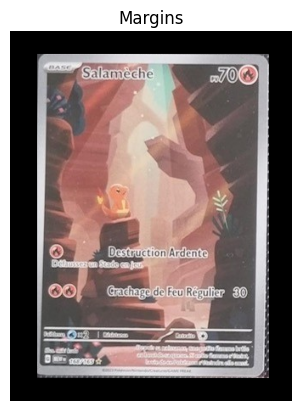

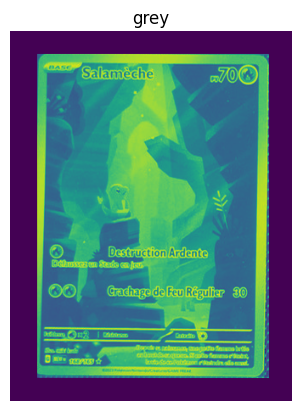

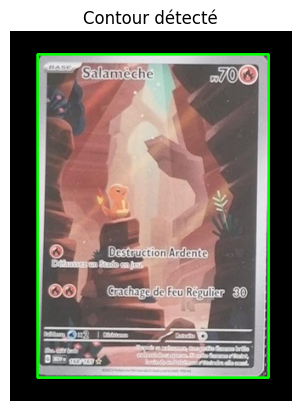

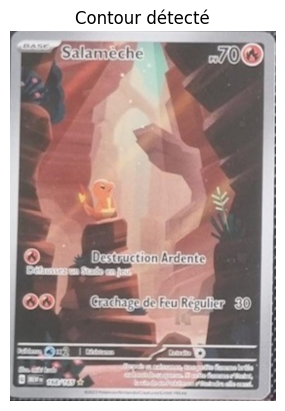

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

def preprocess_img(img):

    border_size = int(min(img.shape[:2]) * 0.10)  # marge = 5% de la taille
    img2 = cv2.copyMakeBorder(
        img2, border_size, border_size, border_size, border_size,
        cv2.BORDER_CONSTANT, value=(0, 0, 0)  # fond noir
        )

    plt.imshow(img2)
    plt.title("Margins")
    plt.axis("off")
    plt.show()

    # Grayscale
    gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    plt.imshow(gray)
    plt.title("grey")
    plt.axis("off")
    plt.show()

    # since findContours alters the image
    contours, hierarchy = cv2.findContours(gray.copy(),
        cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # plus grand contour = carte
    c = max(contours, key=cv2.contourArea)

    img3 = img2.copy()
    cv2.drawContours(img3, c, -1, (0, 255, 0), 2)
    plt.imshow(img3)
    plt.title("Contour détecté")
    plt.axis("off")
    plt.show()


    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(approx) == 4:
        pts = approx.reshape(4, 2)
    else:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        pts = np.int0(box)

    # Réordonne les points
    s = pts.sum(axis=1)
    rect = np.zeros((4, 2), dtype="float32")
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    (w, h) = (460, 640)
    dst = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warp = cv2.warpPerspective(img2, M, (w, h))

    plt.imshow(warp)
    plt.title("Contour détecté")
    plt.axis("off")
    plt.show()
    return warp


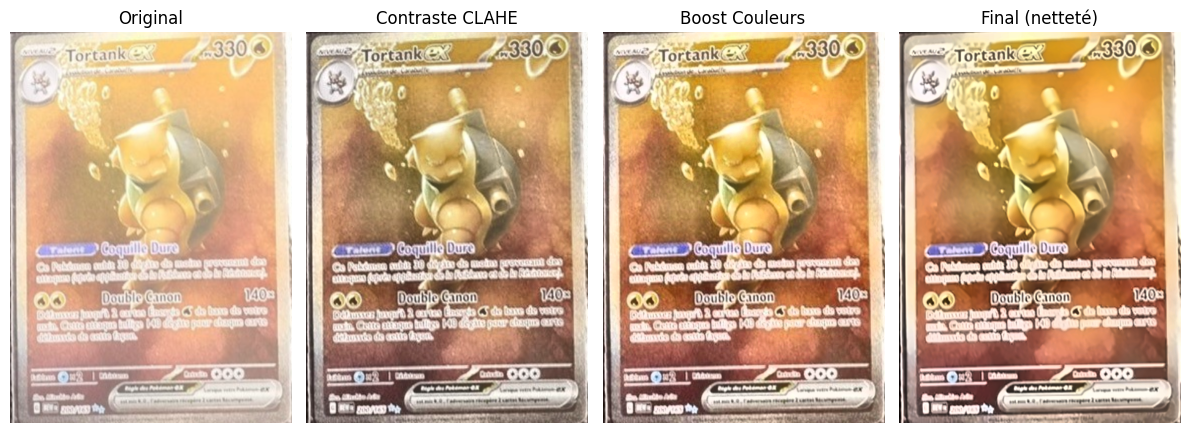

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Chargement ===
img = cv2.imread("data/images/segmented/card_1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def improve_img(img):

    # --- Étape 1 : correction du contraste (CLAHE dans l'espace LAB) ---
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    enhanced_lab = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # --- Étape 2 : boost de saturation et luminosité (espace HSV) ---
    hsv = cv2.cvtColor(enhanced_lab, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    s = np.clip(s * 1.3, 0, 255).astype(np.uint8)
    v = np.clip(v * 1.1, 0, 255).astype(np.uint8)
    hsv_boosted = cv2.merge((h, s, v))
    enhanced_hsv = cv2.cvtColor(hsv_boosted, cv2.COLOR_HSV2RGB)

    # --- Étape 3 : débruitage et renforcement de la netteté ---
    denoised = cv2.fastNlMeansDenoisingColored(enhanced_hsv, None, 5, 5, 7, 21)
    sharp = cv2.addWeighted(denoised, 1.2, cv2.GaussianBlur(denoised, (0, 0), 3), -0.2, 0)

    # === Affichage comparatif ===
    titles = ['Original', 'Contraste CLAHE', 'Boost Couleurs', 'Final (netteté)']
    images = [img, enhanced_lab, enhanced_hsv, sharp]

    #plt.figure(figsize=(12, 8))
    #for i in range(4):
    #    plt.subplot(1, 4, i + 1)
    #    plt.imshow(images[i])
    #    plt.title(titles[i])
    #    plt.axis('off')

    #plt.tight_layout()
    #plt.show()
    return sharp


In [79]:
img = cv2.imread("data/images/segmented/card_2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

template = cv2.imread("data/images/segmented/MEW_200_R_EN_LG.png")
template = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

import cv2
import numpy as np

# === 1. Chargement des images ===    # carte de référence (redressée)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

# === 2. Extraction des points clés (ORB) ===
orb = cv2.ORB_create(2000)
kp1, des1 = orb.detectAndCompute(gray_template, None)
kp2, des2 = orb.detectAndCompute(gray_img, None)

# === 3. Appariement des descripteurs ===
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# On garde les meilleurs (par ex. 10–20%)
good_matches = matches[:int(len(matches)*0.2)]

# === 4. Calcul de l’homographie ===
if len(good_matches) > 4:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

    M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    # === 5. Warp de l’image pour la redresser ===
    h, w = gray_template.shape
    warped = cv2.warpPerspective(img, M, (w, h))

    # === 6. (Optionnel) Sauvegarde des coins détectés ===
    pts = np.float32([[0,0], [w,0], [w,h], [0,h]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, np.linalg.inv(M))

    # Affichage des coins trouvés
    for p in dst:
        cv2.circle(img, tuple(np.int32(p[0])), 8, (0,255,0), -1)

    # === 7. Sauvegarde du résultat ===
    cv2.imwrite("carte_redressee.png", warped)
    print("✅ Carte redressée enregistrée sous 'carte_redressee.png'")
else:
    print("❌ Trop peu de correspondances pour estimer une homographie.")



✅ Carte redressée enregistrée sous 'carte_redressee.png'
